In [6]:
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *


fig_DIR = "../figs/teams/"
box_DIR = "../data/box/"

In [7]:
season = "2022"
df = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{season}_PS.parquet")
df['Team_Split'] = df['MATCHUP'].str.replace("@","")
df['Team_Split'] = df['Team_Split'].str.replace("vs.","")
df[['Team1','Team2']] = df['Team_Split'].str.split("  ",expand=True)
df[["FG3M","PLUS_MINUS","FG3_PCT"]] = df[["FG3M","PLUS_MINUS","FG3_PCT"]].astype(str)

In [8]:
df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE',
       'Team_Split', 'Team1', 'Team2'],
      dtype='object')

# Based on 3FGM

In [9]:
df1 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3M","PLUS_MINUS"]].agg(",".join).reset_index()
df1[["Team1", "Team2"]] = df1["TEAM_ABBREVIATION"].str.split(",", expand=True)
df1[["FG3M_For", "FG3M_Against"]] = df1["FG3M"].str.split(",", expand=True)
df1[["PM1", "PM2"]] = df1["PLUS_MINUS"].str.split(",", expand=True)
df2 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3M","PLUS_MINUS"]].agg(",".join).reset_index()
df2[["Team2", "Team1"]] = df2["TEAM_ABBREVIATION"].str.split(",", expand=True)
df2[["FG3M_Against","FG3M_For"]] = df2["FG3M"].str.split(",", expand=True)
df2[["PM2", "PM1"]] = df2["PLUS_MINUS"].str.split(",", expand=True)

In [10]:
df3 = pd.concat([df1,df2]).sort_values(by="GAME_ID").reset_index(drop=True)
df3 = df3[["Team1","Team2","FG3M_For", "FG3M_Against","PM1","PM2"]]
df3.iloc[:,2:] = df3.iloc[:,2:].astype(int)

In [11]:
df3["More_3PT"] = df3["FG3M_For"] > df3["FG3M_Against"]
df3["Less_3PT"] = df3["FG3M_For"] <= df3["FG3M_Against"]
df3["Win"] = df3["PM1"] > 0
df3["Loss"] = df3["PM1"] < 0
df3["Win_More_3PT"] = df3["More_3PT"] & df3["Win"]
df3["Win_Less_3PT"] = df3["Less_3PT"] & df3["Win"]
df3["Loss_More_3PT"] = df3["More_3PT"] & df3["Loss"]
df3["Loss_Less_3PT"] = df3["Less_3PT"] & df3["Loss"]

In [12]:
df4 = df3.groupby("Team1")[["Win_More_3PT","Win_Less_3PT","Loss_More_3PT","Loss_Less_3PT"]]\
.agg({"Win_More_3PT":["sum"],"Win_Less_3PT":["sum"],"Loss_More_3PT":["sum"],"Loss_Less_3PT":["sum"]})
df4.columns = ["Win_More_3PT","Win_Less_3PT","Loss_More_3PT","Loss_Less_3PT"]
df4 = df4.sort_values(by="Win_More_3PT",ascending=False).reset_index().rename(columns={"Team1":"Team"})
df4.loc['Total']= df4.sum()
df4.loc['Total','Team'] = "Total"

In [13]:
d = (
    GT(data=df4.iloc[:15])
    # .cols_label(For_30= "30 PTS For", Against_30="30 PTS Against", Diff_30="Difference")
    .cols_align(align="center", columns=["Win_More_3PT","Win_Less_3PT","Loss_More_3PT","Loss_Less_3PT"])
    .tab_spanner(
        label = "More 3PT",
        columns = ["Win_More_3PT", "Loss_More_3PT"]
    )
    .tab_spanner(
        label = "Less 3PT",
        columns = ["Win_Less_3PT", "Loss_Less_3PT"]
    )
    .tab_header(
        title="Team Win Loss When Making More 3 Pointers than Opponent",
    )
    .cols_label(Win_More_3PT = "Wins",Win_Less_3PT = "Wins", Loss_More_3PT = "Losses",Loss_Less_3PT = "Losses")
    .tab_source_note(
        source_note = "@SravanNBA | source: nba.com/stats"
    )
)
d

GT(_tbl_data=   Team  Win_More_3PT  Win_Less_3PT  Loss_More_3PT  Loss_Less_3PT
0   DEN            11             5              1              3
1   MIA             9             4              5              5
2   BOS             8             3              3              6
3   GSW             5             1              4              3
4   LAL             4             4              0              8
5   PHI             3             4              0              4
6   MEM             2             0              1              3
7   NYK             2             4              2              3
8   ATL             1             1              1              3
9   CLE             1             0              2              2
10  LAC             1             0              3              1
11  MIL             1             0              0              4
12  MIN             1             0              1              3
13  PHX             1             5              1              4
14  SAC             1             2              0              4, _body=<great_tables._gt_data.Body object at 0x0000028C6A61C650>, _boxhead=Boxhead([ColInfo(var='Team', type=<ColInfoTypeEnum.default: 1>, column_label='Team', column_align='left', column_width=None), ColInfo(var='Win_More_3PT', type=<ColInfoTypeEnum.default: 1>, column_label='Wins', column_align='center', column_width=None), ColInfo(var='Loss_More_3PT', type=<ColInfoTypeEnum.default: 1>, column_label='Losses', column_align='center', column_width=None), ColInfo(var='Win_Less_3PT', type=<ColInfoTypeEnum.default: 1>, column_label='Wins', column_align='center', column_width=None), ColInfo(var='Loss_Less_3PT', type=<ColInfoTypeEnum.default: 1>, column_label='Losses', column_align='center', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=7, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=8, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=9, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=10, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=11, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=12, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=13, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=14, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([SpannerInfo(spanner_id='More 3PT', spanner_level=0, spanner_label='More 3PT', spanner_units=None, spanner_pattern=None, vars=['Win_More_3PT', 'Loss_More_3PT'], built=None), SpannerInfo(spanner_id='Less 3PT', spanner_level=0, spanner_label='Less 3PT', spanner_units=None, spanner_pattern=None, vars=['Win_Less_3PT', 'Loss_Less_3PT'], built=None)]), _heading=Heading(title='Team Win Loss When Making More 3 Pointers than Opponent', subtitle=None, preheader=None), _stubhead=None, _source_notes=['@SravanNBA | source: nba.com/stats'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000028C6A4FC590>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), 

In [14]:
d = (
    GT(data=df4.iloc[15:])
    # .cols_label(For_30= "30 PTS For", Against_30="30 PTS Against", Diff_30="Difference")
    .cols_align(align="center", columns=["Win_More_3PT","Win_Less_3PT","Loss_More_3PT","Loss_Less_3PT"])
    .tab_spanner(
        label = "More 3PT",
        columns = ["Win_More_3PT", "Loss_More_3PT"]
    )
    .tab_spanner(
        label = "Less 3PT",
        columns = ["Win_Less_3PT", "Loss_Less_3PT"]
    )
    .tab_header(
        title="Team Win Loss When Making More 3 Pointers than Opponent",
    )
    .cols_label(Win_More_3PT = "Wins",Win_Less_3PT = "Wins", Loss_More_3PT = "Losses",Loss_Less_3PT = "Losses")
    .tab_source_note(
        source_note = "@SravanNBA | source: nba.com/stats"
    )
)
d

GT(_tbl_data=        Team  Win_More_3PT  Win_Less_3PT  Loss_More_3PT  Loss_Less_3PT
15       BKN             0             0              1              3
Total  Total            51            33             25             59, _body=<great_tables._gt_data.Body object at 0x0000028C677D4850>, _boxhead=Boxhead([ColInfo(var='Team', type=<ColInfoTypeEnum.default: 1>, column_label='Team', column_align='left', column_width=None), ColInfo(var='Win_More_3PT', type=<ColInfoTypeEnum.default: 1>, column_label='Wins', column_align='center', column_width=None), ColInfo(var='Loss_More_3PT', type=<ColInfoTypeEnum.default: 1>, column_label='Losses', column_align='center', column_width=None), ColInfo(var='Win_Less_3PT', type=<ColInfoTypeEnum.default: 1>, column_label='Wins', column_align='center', column_width=None), ColInfo(var='Loss_Less_3PT', type=<ColInfoTypeEnum.default: 1>, column_label='Losses', column_align='center', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([SpannerInfo(spanner_id='More 3PT', spanner_level=0, spanner_label='More 3PT', spanner_units=None, spanner_pattern=None, vars=['Win_More_3PT', 'Loss_More_3PT'], built=None), SpannerInfo(spanner_id='Less 3PT', spanner_level=0, spanner_label='Less 3PT', spanner_units=None, spanner_pattern=None, vars=['Win_Less_3PT', 'Loss_Less_3PT'], built=None)]), _heading=Heading(title='Team Win Loss When Making More 3 Pointers than Opponent', subtitle=None, preheader=None), _stubhead=None, _source_notes=['@SravanNBA | source: nba.com/stats'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000028C43529810>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), ta

# Based on 3PT%

In [15]:
df1 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3_PCT","PLUS_MINUS"]].agg(",".join).reset_index()
df1[["Team1", "Team2"]] = df1["TEAM_ABBREVIATION"].str.split(",", expand=True)
df1[["FG3_PCT_For", "FG3_PCT_Against"]] = df1["FG3_PCT"].str.split(",", expand=True)
df1[["PM1", "PM2"]] = df1["PLUS_MINUS"].str.split(",", expand=True)
df2 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3_PCT","PLUS_MINUS"]].agg(",".join).reset_index()
df2[["Team2", "Team1"]] = df2["TEAM_ABBREVIATION"].str.split(",", expand=True)
df2[["FG3_PCT_Against","FG3_PCT_For"]] = df2["FG3_PCT"].str.split(",", expand=True)
df2[["PM2", "PM1"]] = df2["PLUS_MINUS"].str.split(",", expand=True)

In [16]:
df3 = pd.concat([df1,df2]).sort_values(by="GAME_ID").reset_index(drop=True)
df3 = df3[["Team1","Team2","FG3_PCT_For", "FG3_PCT_Against","PM1","PM2"]]
df3.iloc[:,2:] = df3.iloc[:,2:].astype(float)

In [17]:
df3["More_3PT_PCT"] = df3["FG3_PCT_For"] > (df3["FG3_PCT_Against"] +0.1)
df3["Win"] = df3["PM1"] > 0
df3["Loss"] = df3["PM1"] < 0
df3["Win_More_3PT_PCT"] = df3["More_3PT_PCT"] & df3["Win"]
df3["Loss_More_3PT_PCT"] = df3["More_3PT_PCT"] & df3["Loss"]

In [18]:
df4 = df3.groupby("Team1")[["Win_More_3PT_PCT","Loss_More_3PT_PCT"]]\
.agg({"Win_More_3PT_PCT":["sum"],"Loss_More_3PT_PCT":["sum"]})
df4.columns = ["Win_More_3PT_PCT","Loss_More_3PT_PCT"]
df4 = df4.sort_values(by="Win_More_3PT_PCT",ascending=False).reset_index().rename(columns={"Team1":"Team"})
df4.loc['Total']= df4.sum()
df4.loc['Total','Team'] = "Total"

In [19]:
d = (
    GT(data=df4)
    # .cols_label(For_30= "30 PTS For", Against_30="30 PTS Against", Diff_30="Difference")
    .cols_align(align="center", columns=["Win_More_3PT_PCT","Loss_More_3PT_PCT"])
    .tab_spanner(
        label = "3PT % > Opponent by 10%",
        columns = ["Win_More_3PT_PCT", "Loss_More_3PT_PCT"]
    )
    .tab_header(
        title="Team Win Loss When 3PT% greater than Opponent by 10%",
    )
    .cols_label(Win_More_3PT_PCT = "Wins",Loss_More_3PT_PCT = "Losses")
    .tab_source_note(
        source_note = "@SravanNBA | source: nba.com/stats"
    )
)
d

GT(_tbl_data=        Team  Win_More_3PT_PCT  Loss_More_3PT_PCT
0        DEN                 7                  0
1        BOS                 6                  0
2        MIA                 5                  1
3        LAL                 2                  0
4        PHX                 2                  0
5        ATL                 1                  0
6        CLE                 1                  0
7        GSW                 1                  1
8        PHI                 1                  0
9        BKN                 0                  0
10       LAC                 0                  0
11       MEM                 0                  0
12       MIL                 0                  0
13       MIN                 0                  0
14       NYK                 0                  0
15       SAC                 0                  0
Total  Total                26                  2, _body=<great_tables._gt_data.Body object at 0x0000028C44184050>, _boxhead=Boxhead([ColInfo(var='Team', type=<ColInfoTypeEnum.default: 1>, column_label='Team', column_align='left', column_width=None), ColInfo(var='Win_More_3PT_PCT', type=<ColInfoTypeEnum.default: 1>, column_label='Wins', column_align='center', column_width=None), ColInfo(var='Loss_More_3PT_PCT', type=<ColInfoTypeEnum.default: 1>, column_label='Losses', column_align='center', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=7, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=8, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=9, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=10, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=11, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=12, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=13, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=14, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=15, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=16, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([SpannerInfo(spanner_id='3PT % > Opponent by 10%', spanner_level=0, spanner_label='3PT % > Opponent by 10%', spanner_units=None, spanner_pattern=None, vars=['Win_More_3PT_PCT', 'Loss_More_3PT_PCT'], built=None)]), _heading=Heading(title='Team Win Loss When 3PT% greater than Opponent by 10%', subtitle=None, preheader=None), _stubhead=None, _source_notes=['@SravanNBA | source: nba.com/stats'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000028C6A767B10>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_font_names=OptionsInfo

# 3PT Shooting Year to Year Trends

In [20]:
from nba_api.stats.endpoints import leaguedashteamstats


In [30]:
dfa = []
for year in range(2013,2023):
    season = str(year) + "-" + str(year + 1)[-2:]
    print(season)
    stats = leaguedashteamstats.LeagueDashTeamStats(per_mode_detailed="PerGame", season_type_all_star="Playoffs", season = season)
    df = stats.get_data_frames()[0]
    df = df[["TEAM_NAME","W","L","W_PCT","FG3M","FG3A","FG3_PCT"]]
    df.loc["Total"] = df.sum()
    df.loc["Total","FG3M"] = df.loc["Total","FG3M"]/30
    df.loc["Total","FG3A"] = df.loc["Total","FG3A"]/30 
    df.loc["Total","FG3_PCT"] = df.loc["Total","FG3M"]/df.loc["Total","FG3A"]
    df.loc["Total","TEAM_NAME"] = year +1
    df.iloc[:,4:] = df.iloc[:,4:].round(3)
    dft = df.tail(1)
    dft = dft[["TEAM_NAME","FG3M", "FG3A", "FG3_PCT"]]
    dfa.append(dft)
df_3pct = pd.concat(dfa)

2013-14
2014-15
2015-16
2016-17
2017-18
2018-19
2019-20
2020-21
2021-22
2022-23


In [31]:
df_3pct = df_3pct.rename(columns={"TEAM_NAME":"Season"}).reset_index(drop=True)

In [32]:
df_3pct

,Season,FG3M,FG3A,FG3_PCT
0,2014,4.203,11.997,0.350
1,2015,4.380,12.977,0.338
2,2016,4.450,13.060,0.341
3,2017,5.303,14.997,0.354
4,2018,5.427,15.277,0.355
5,2019,5.833,17.357,0.336
6,2020,6.993,19.520,0.358
7,2021,6.587,18.233,0.361
8,2022,6.197,17.797,0.348
9,2023,6.410,18.513,0.346


In [33]:
theme_idv = themes.theme_xkcd(base_size=11)
theme_idv += theme(
    plot_title=element_text(face="bold", size=16),
)

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/teams/FG3A_seasons.png


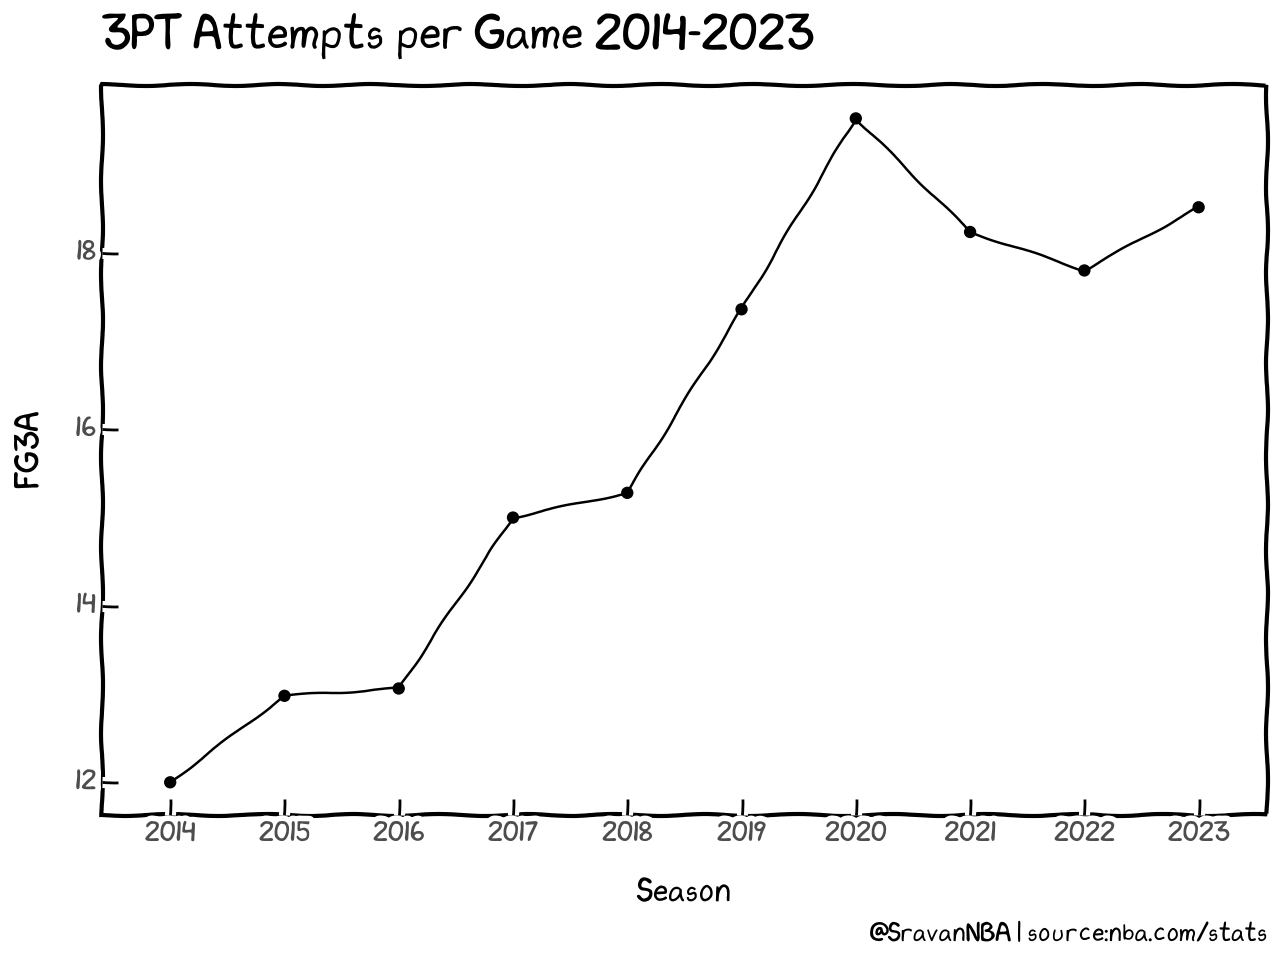

In [34]:
p = (
    ggplot(df_3pct)
    + aes(x="Season", y= "FG3A")
    + geom_line(group=1)
    + geom_point()
    + theme_idv
    + labs(
            title= "3PT Attempts per Game 2014-2023",
            caption="@SravanNBA | source:nba.com/stats",
        )
)
p.draw()

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/teams/FG3M_seasons.png


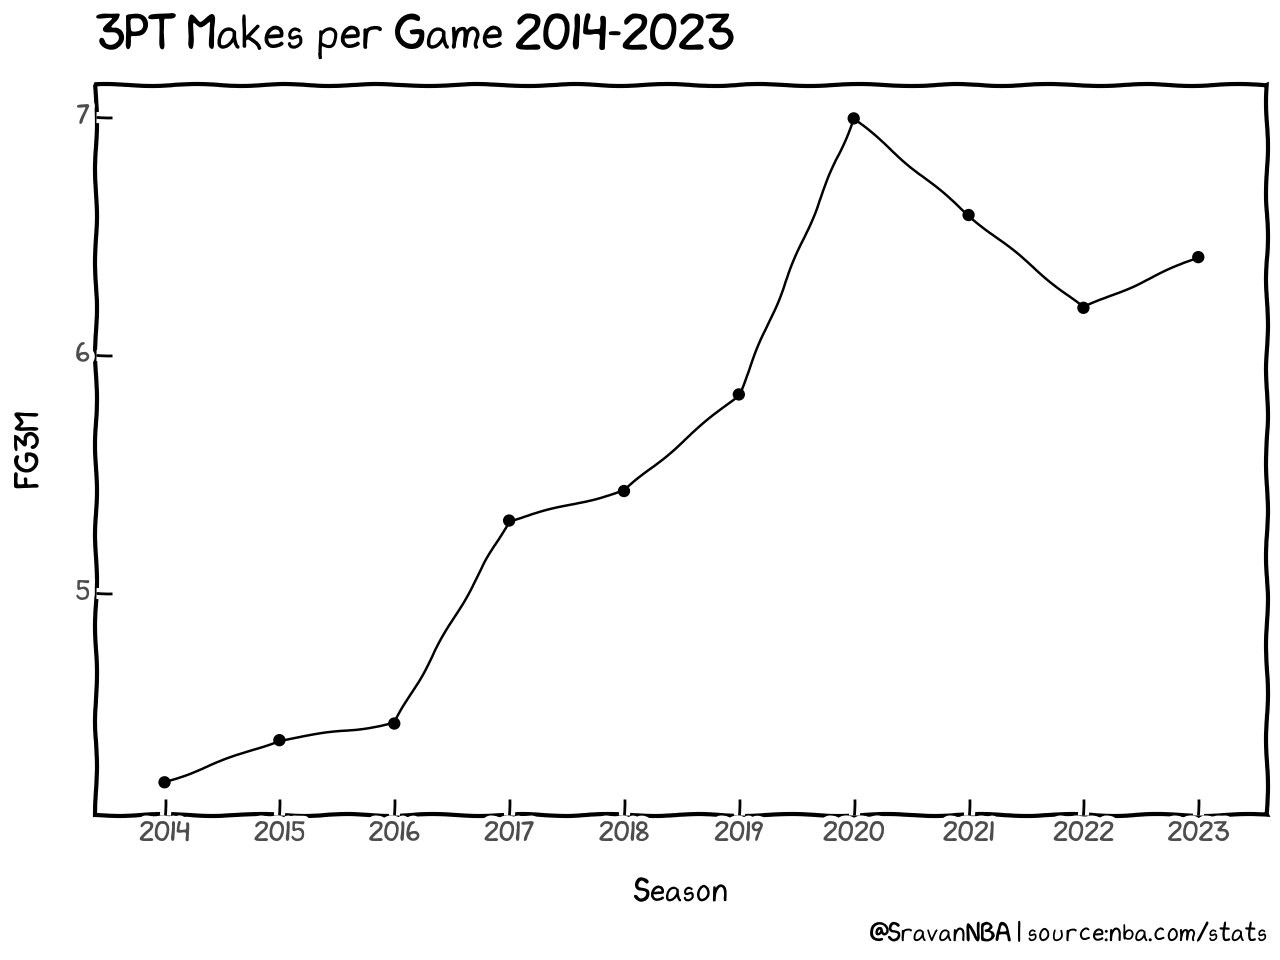

In [35]:
p = (
    ggplot(df_3pct)
    + aes(x="Season", y= "FG3M")
    + geom_line(group=1)
    + geom_point()
    + theme_idv
    + labs(
            title= "3PT Makes per Game 2014-2023",
            caption="@SravanNBA | source:nba.com/stats",
        )
)
p.draw()

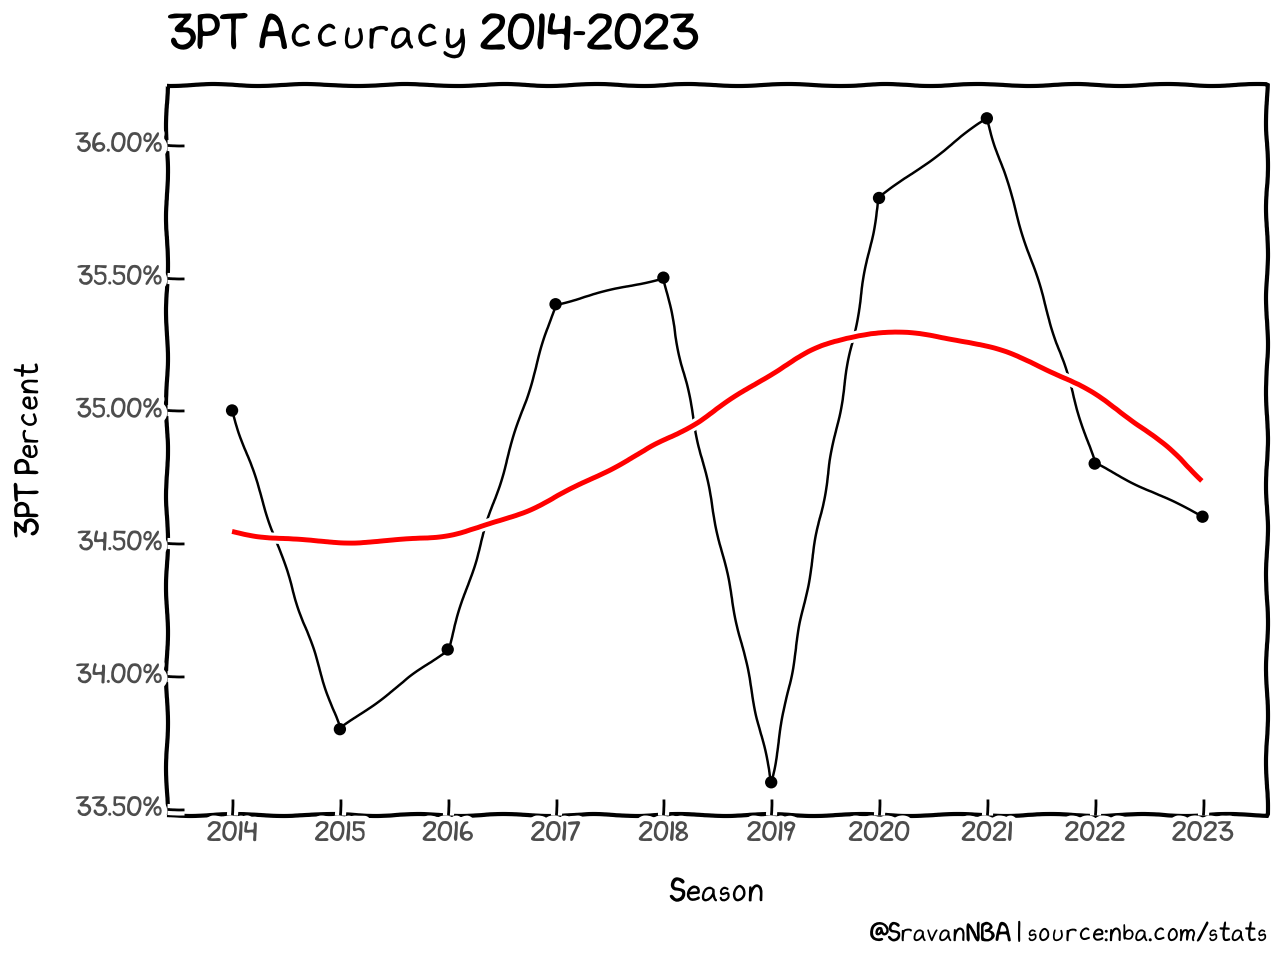

In [47]:
p = (
    ggplot(df_3pct)
    + aes(x="Season", y= "FG3_PCT",group=1)
    + geom_line()
    + geom_point()
    + geom_smooth(color="red",se=False,span=1)
    + scale_y_continuous(labels=percent_format())
    + theme_idv
    + labs(
            title= "3PT Accuracy 2014-2023",
            caption="@SravanNBA | source:nba.com/stats",
            y="3PT Percent"
        )
)
p.draw()

In [37]:
asda

NameError: name 'asda' is not defined

# 3FGA vs Wins Year to Year

### Team 3PA > Opponent 3PA

In [49]:
dfa = []
for season in range(2013,2023):
    df = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{season}_PS.parquet")
    df['Team_Split'] = df['MATCHUP'].str.replace("@","")
    df['Team_Split'] = df['Team_Split'].str.replace("vs.","")
    df[['Team1','Team2']] = df['Team_Split'].str.split("  ",expand=True)
    df[["FG3A","PLUS_MINUS","FG3_PCT"]] = df[["FG3A","PLUS_MINUS","FG3_PCT"]].astype(str)
    df1 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3A","PLUS_MINUS"]].agg(",".join).reset_index()
    df1[["Team1", "Team2"]] = df1["TEAM_ABBREVIATION"].str.split(",", expand=True)
    df1[["FG3A_For", "FG3A_Against"]] = df1["FG3A"].str.split(",", expand=True)
    df1[["PM1", "PM2"]] = df1["PLUS_MINUS"].str.split(",", expand=True)
    df2 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3A","PLUS_MINUS"]].agg(",".join).reset_index()
    df2[["Team2", "Team1"]] = df2["TEAM_ABBREVIATION"].str.split(",", expand=True)
    df2[["FG3A_Against","FG3A_For"]] = df2["FG3A"].str.split(",", expand=True)
    df2[["PM2", "PM1"]] = df2["PLUS_MINUS"].str.split(",", expand=True)
    df3 = pd.concat([df1,df2]).sort_values(by="GAME_ID").reset_index(drop=True)
    df3 = df3[["Team1","Team2","FG3A_For", "FG3A_Against","PM1","PM2"]]
    df3.iloc[:,2:] = df3.iloc[:,2:].astype(int)
    df3["More_3PT"] = df3["FG3A_For"] > (df3["FG3A_Against"] + 0)
    df3["Win"] = df3["PM1"] > 0
    df3["Loss"] = df3["PM1"] < 0
    df3["Win_More_3PT"] = df3["More_3PT"] & df3["Win"]
    df3["Loss_More_3PT"] = df3["More_3PT"] & df3["Loss"]
    df4 = df3.groupby("Team1")[["Win_More_3PT","Loss_More_3PT"]]\
        .agg({"Win_More_3PT":["sum"],"Loss_More_3PT":["sum"]})
    df4.columns = ["Win_More_3PT","Loss_More_3PT"]
    df4 = df4.sort_values(by="Win_More_3PT",ascending=False).reset_index().rename(columns={"Team1":"Team"})
    df4.loc['Total']= df4.sum()
    df4.loc['Total','Team'] = "Total"
    df4.loc['Total','Team'] = season +1
    dft = df4.tail(1)
    dfa.append(dft)
df_aw = pd.concat(dfa).reset_index(drop=True)
df_aw = df_aw.rename(columns={"Team":"Season"})
df_aw["Win_PCT"] = (df_aw["Win_More_3PT"]/(df_aw["Win_More_3PT"]+df_aw["Loss_More_3PT"])).round(3)

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/teams/FG3A_Wins_seasons.png


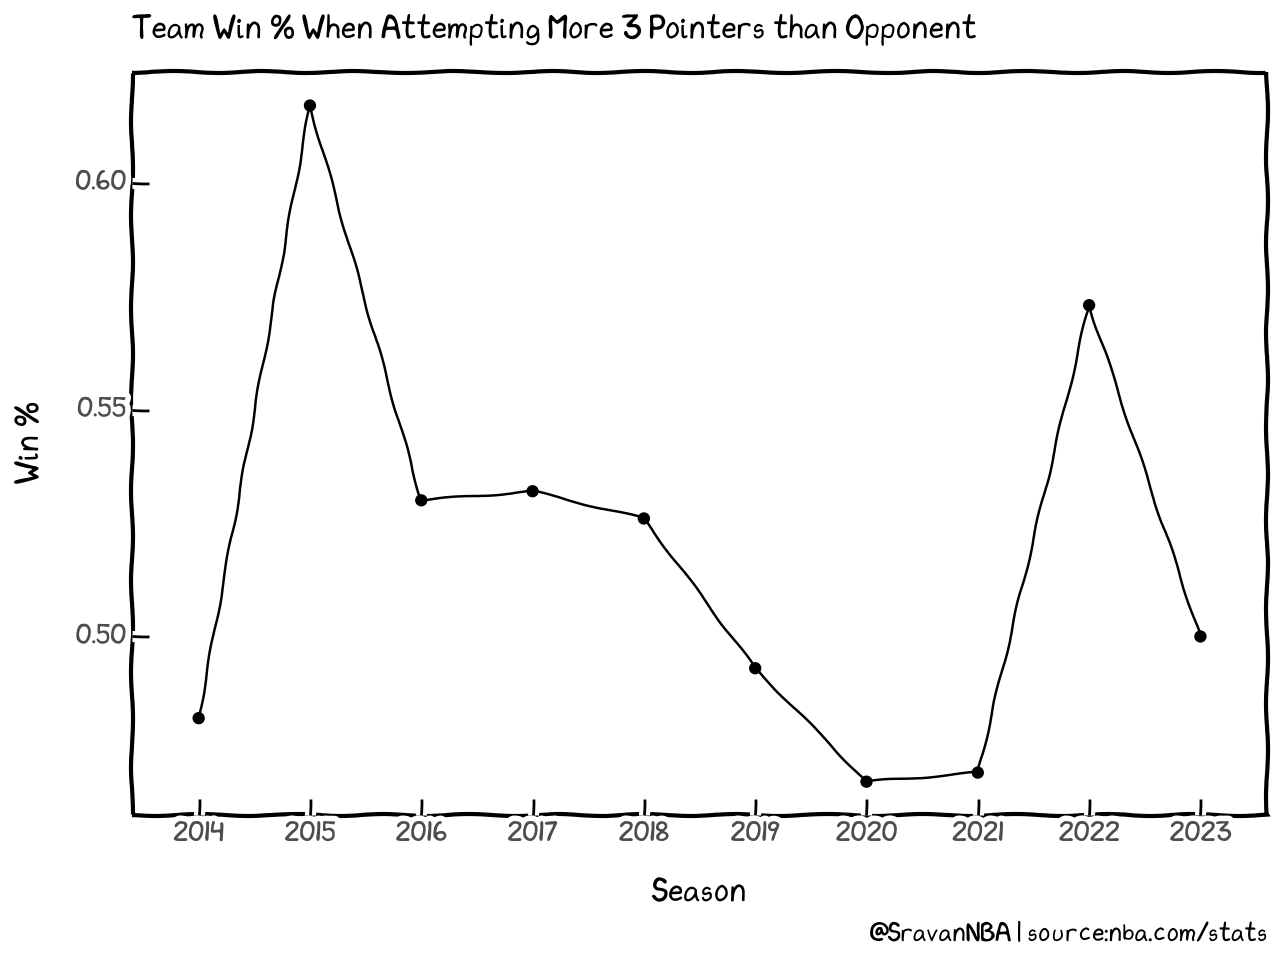

In [50]:
p = (
    ggplot(df_aw)
    + aes(x="Season", y= "Win_PCT")
    + geom_line(group=1)
    + geom_point()
    + theme_idv
    + labs(
            title= "Team Win % When Attempting More 3 Pointers than Opponent",
            caption="@SravanNBA | source:nba.com/stats",
            y = "Win %",
        )
    + theme(plot_title=element_text(face="bold", size=11))
)
p.draw()

### Team 3PA > Opponent 3PA + 5

In [63]:
dfa = []
for season in range(2013,2023):
    df = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{season}_PS.parquet")
    df['Team_Split'] = df['MATCHUP'].str.replace("@","")
    df['Team_Split'] = df['Team_Split'].str.replace("vs.","")
    df[['Team1','Team2']] = df['Team_Split'].str.split("  ",expand=True)
    df[["FG3A","PLUS_MINUS","FG3_PCT"]] = df[["FG3A","PLUS_MINUS","FG3_PCT"]].astype(str)
    df1 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3A","PLUS_MINUS"]].agg(",".join).reset_index()
    df1[["Team1", "Team2"]] = df1["TEAM_ABBREVIATION"].str.split(",", expand=True)
    df1[["FG3A_For", "FG3A_Against"]] = df1["FG3A"].str.split(",", expand=True)
    df1[["PM1", "PM2"]] = df1["PLUS_MINUS"].str.split(",", expand=True)
    df2 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3A","PLUS_MINUS"]].agg(",".join).reset_index()
    df2[["Team2", "Team1"]] = df2["TEAM_ABBREVIATION"].str.split(",", expand=True)
    df2[["FG3A_Against","FG3A_For"]] = df2["FG3A"].str.split(",", expand=True)
    df2[["PM2", "PM1"]] = df2["PLUS_MINUS"].str.split(",", expand=True)
    df3 = pd.concat([df1,df2]).sort_values(by="GAME_ID").reset_index(drop=True)
    df3 = df3[["Team1","Team2","FG3A_For", "FG3A_Against","PM1","PM2"]]
    df3.iloc[:,2:] = df3.iloc[:,2:].astype(int)
    df3["More_3PT"] = df3["FG3A_For"] > (df3["FG3A_Against"] + 0)
    df3["Win"] = df3["PM1"] > 0
    df3["Loss"] = df3["PM1"] < 0
    df3["Win_More_3PT"] = df3["More_3PT"] & df3["Win"]
    df3["Loss_More_3PT"] = df3["More_3PT"] & df3["Loss"]
    df4 = df3.groupby("Team1")[["Win_More_3PT","Loss_More_3PT"]]\
        .agg({"Win_More_3PT":["sum"],"Loss_More_3PT":["sum"]})
    df4.columns = ["Win_More_3PT","Loss_More_3PT"]
    df4 = df4.sort_values(by="Win_More_3PT",ascending=False).reset_index().rename(columns={"Team1":"Team"})
    df4.loc['Total']= df4.sum()
    df4.loc['Total','Team'] = "Total"
    df4.loc['Total','Team'] = season +1
    dft = df4.tail(1)
    dfa.append(dft)
df_aw = pd.concat(dfa).reset_index(drop=True)
df_aw = df_aw.rename(columns={"Team":"Season"})
df_aw["Win_PCT"] = (df_aw["Win_More_3PT"]/(df_aw["Win_More_3PT"]+df_aw["Loss_More_3PT"])).round(3)

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 5.2 x 4 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/teams/FG3A_Wins_seasons_1.png


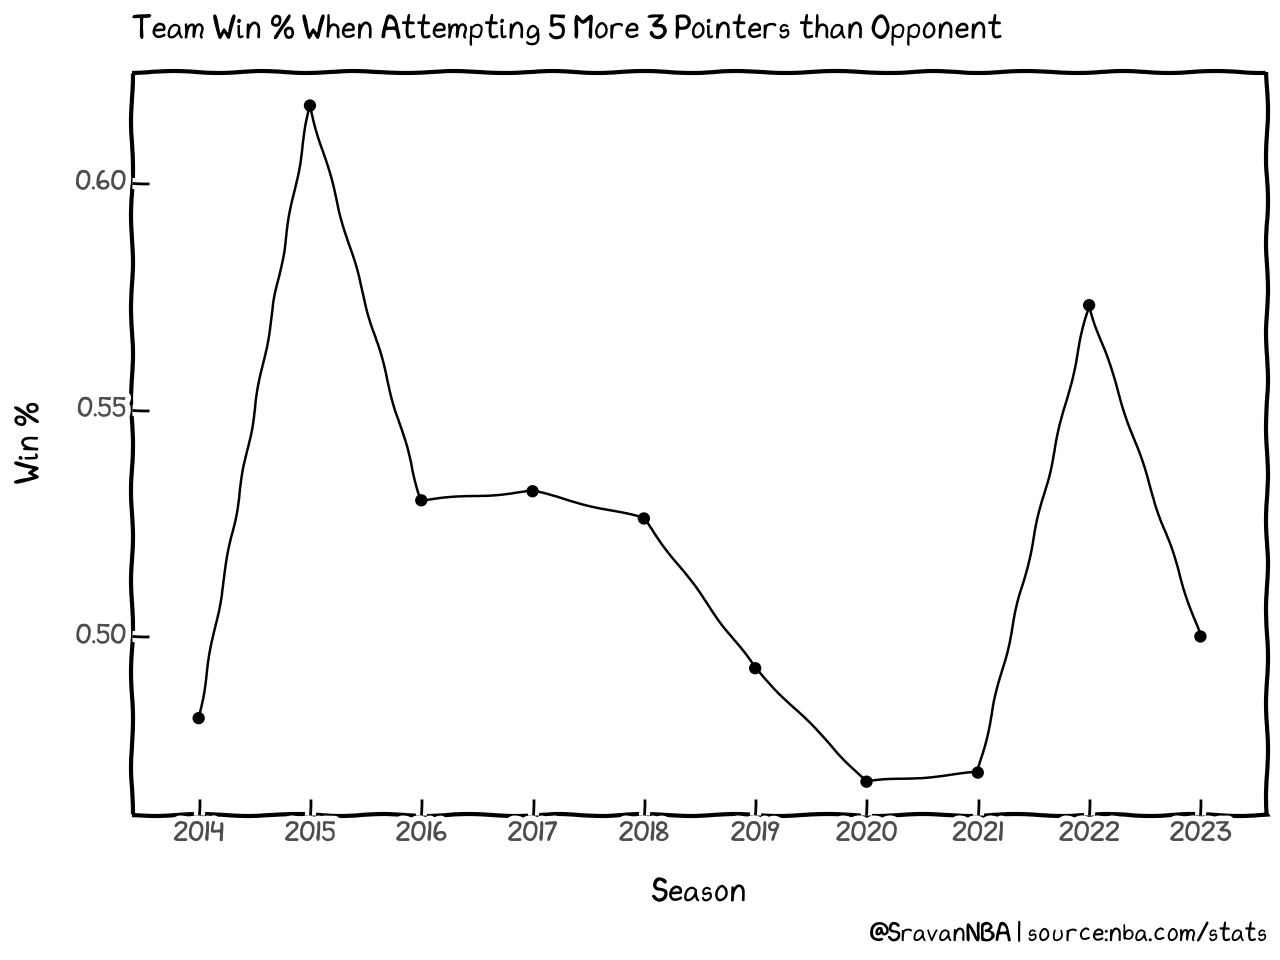

In [64]:
p = (
    ggplot(df_aw)
    + aes(x="Season", y= "Win_PCT")
    + geom_line(group=1)
    + geom_point()
    + theme_idv
    + labs(
            title= "Team Win % When Attempting 5 More 3 Pointers than Opponent",
            caption="@SravanNBA | source:nba.com/stats",
            y = "Win %",
        )
    + theme(plot_title=element_text(face="bold", size=11))
)
p.draw()

# 3FGM vs Wins Year to Year

### Team 3PM > Opponent 3PM

In [65]:
dfa = []
for season in range(2013,2023):
    df = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{season}_PS.parquet")
    df['Team_Split'] = df['MATCHUP'].str.replace("@","")
    df['Team_Split'] = df['Team_Split'].str.replace("vs.","")
    df[['Team1','Team2']] = df['Team_Split'].str.split("  ",expand=True)
    df[["FG3M","PLUS_MINUS","FG3_PCT"]] = df[["FG3M","PLUS_MINUS","FG3_PCT"]].astype(str)
    df1 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3M","PLUS_MINUS"]].agg(",".join).reset_index()
    df1[["Team1", "Team2"]] = df1["TEAM_ABBREVIATION"].str.split(",", expand=True)
    df1[["FG3M_For", "FG3M_Against"]] = df1["FG3M"].str.split(",", expand=True)
    df1[["PM1", "PM2"]] = df1["PLUS_MINUS"].str.split(",", expand=True)
    df2 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3M","PLUS_MINUS"]].agg(",".join).reset_index()
    df2[["Team2", "Team1"]] = df2["TEAM_ABBREVIATION"].str.split(",", expand=True)
    df2[["FG3M_Against","FG3M_For"]] = df2["FG3M"].str.split(",", expand=True)
    df2[["PM2", "PM1"]] = df2["PLUS_MINUS"].str.split(",", expand=True)
    df3 = pd.concat([df1,df2]).sort_values(by="GAME_ID").reset_index(drop=True)
    df3 = df3[["Team1","Team2","FG3M_For", "FG3M_Against","PM1","PM2"]]
    df3.iloc[:,2:] = df3.iloc[:,2:].astype(int)
    df3["More_3PT"] = df3["FG3M_For"] > (df3["FG3M_Against"])
    df3["Win"] = df3["PM1"] > 0
    df3["Loss"] = df3["PM1"] < 0
    df3["Win_More_3PT"] = df3["More_3PT"] & df3["Win"]
    df3["Loss_More_3PT"] = df3["More_3PT"] & df3["Loss"]
    df4 = df3.groupby("Team1")[["Win_More_3PT","Loss_More_3PT"]]\
        .agg({"Win_More_3PT":["sum"],"Loss_More_3PT":["sum"]})
    df4.columns = ["Win_More_3PT","Loss_More_3PT"]
    df4 = df4.sort_values(by="Win_More_3PT",ascending=False).reset_index().rename(columns={"Team1":"Team"})
    df4.loc['Total']= df4.sum()
    df4.loc['Total','Team'] = "Total"
    df4.loc['Total','Team'] = season +1
    dft = df4.tail(1)
    dfa.append(dft)
df_mw = pd.concat(dfa).reset_index(drop=True)
df_mw = df_mw.rename(columns={"Team":"Season"})
df_mw["Win_PCT"] = (df_mw["Win_More_3PT"]/(df_mw["Win_More_3PT"]+df_mw["Loss_More_3PT"])).round(3)

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/teams/FG3M_Wins_seasons.png


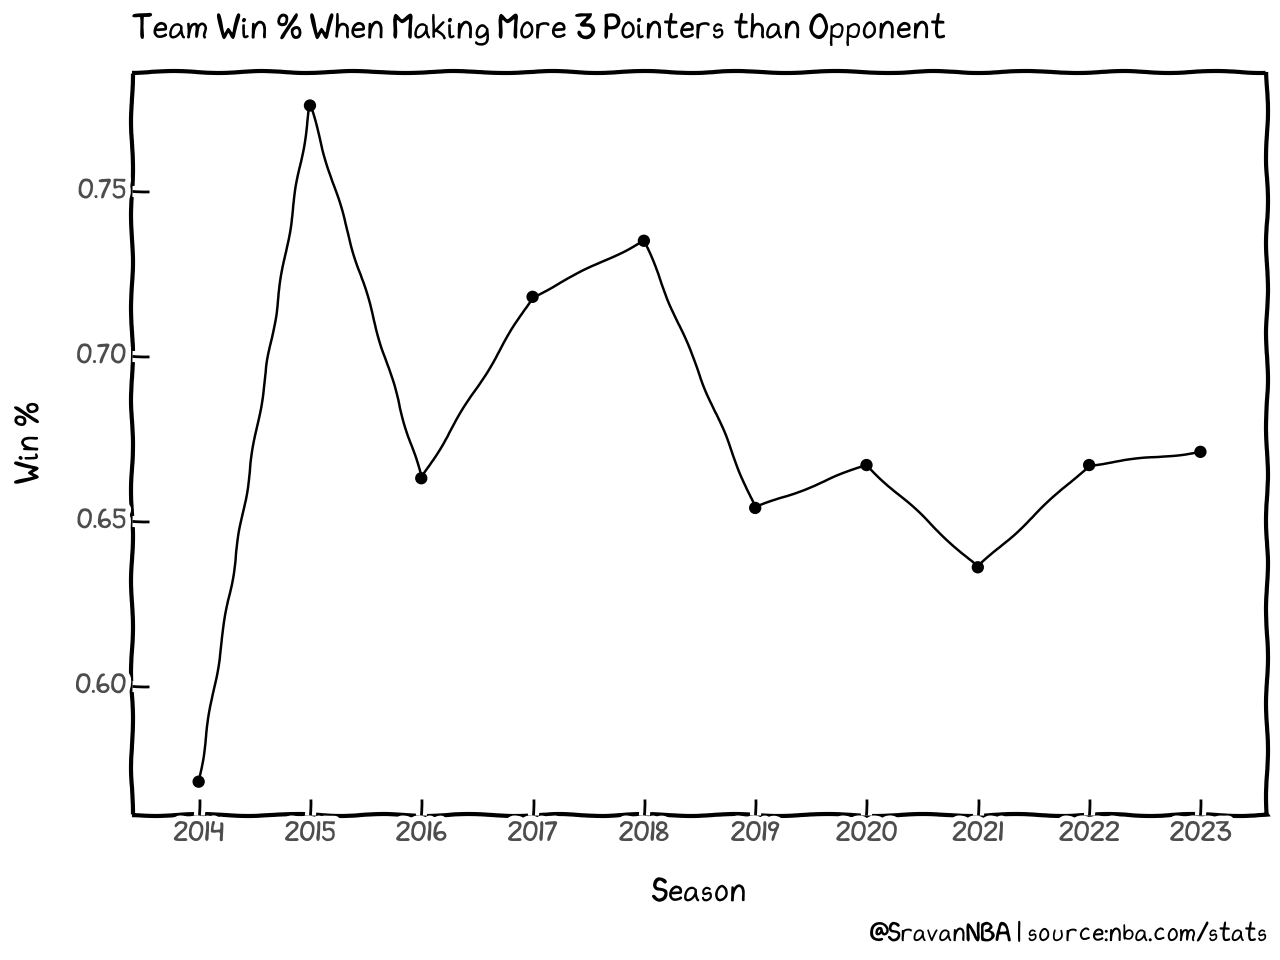

In [66]:
p = (
    ggplot(df_mw)
    + aes(x="Season", y= "Win_PCT")
    + geom_line(group=1)
    + geom_point()
    + theme_idv
    + labs(
            title= "Team Win % When Making More 3 Pointers than Opponent",
            caption="@SravanNBA | source:nba.com/stats",
            y = "Win %",
        )
    + theme(plot_title=element_text(face="bold", size=11.5))
)
p.draw()

### Team 3PM > Opponent 3PM + 2

In [67]:
dfa = []
for season in range(2013,2023):
    df = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{season}_PS.parquet")
    df['Team_Split'] = df['MATCHUP'].str.replace("@","")
    df['Team_Split'] = df['Team_Split'].str.replace("vs.","")
    df[['Team1','Team2']] = df['Team_Split'].str.split("  ",expand=True)
    df[["FG3M","PLUS_MINUS","FG3_PCT"]] = df[["FG3M","PLUS_MINUS","FG3_PCT"]].astype(str)
    df1 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3M","PLUS_MINUS"]].agg(",".join).reset_index()
    df1[["Team1", "Team2"]] = df1["TEAM_ABBREVIATION"].str.split(",", expand=True)
    df1[["FG3M_For", "FG3M_Against"]] = df1["FG3M"].str.split(",", expand=True)
    df1[["PM1", "PM2"]] = df1["PLUS_MINUS"].str.split(",", expand=True)
    df2 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3M","PLUS_MINUS"]].agg(",".join).reset_index()
    df2[["Team2", "Team1"]] = df2["TEAM_ABBREVIATION"].str.split(",", expand=True)
    df2[["FG3M_Against","FG3M_For"]] = df2["FG3M"].str.split(",", expand=True)
    df2[["PM2", "PM1"]] = df2["PLUS_MINUS"].str.split(",", expand=True)
    df3 = pd.concat([df1,df2]).sort_values(by="GAME_ID").reset_index(drop=True)
    df3 = df3[["Team1","Team2","FG3M_For", "FG3M_Against","PM1","PM2"]]
    df3.iloc[:,2:] = df3.iloc[:,2:].astype(int)
    df3["More_3PT"] = df3["FG3M_For"] > (df3["FG3M_Against"] + 2)
    df3["Win"] = df3["PM1"] > 0
    df3["Loss"] = df3["PM1"] < 0
    df3["Win_More_3PT"] = df3["More_3PT"] & df3["Win"]
    df3["Loss_More_3PT"] = df3["More_3PT"] & df3["Loss"]
    df4 = df3.groupby("Team1")[["Win_More_3PT","Loss_More_3PT"]]\
        .agg({"Win_More_3PT":["sum"],"Loss_More_3PT":["sum"]})
    df4.columns = ["Win_More_3PT","Loss_More_3PT"]
    df4 = df4.sort_values(by="Win_More_3PT",ascending=False).reset_index().rename(columns={"Team1":"Team"})
    df4.loc['Total']= df4.sum()
    df4.loc['Total','Team'] = "Total"
    df4.loc['Total','Team'] = season +1
    dft = df4.tail(1)
    dfa.append(dft)
df_mw = pd.concat(dfa).reset_index(drop=True)
df_mw = df_mw.rename(columns={"Team":"Season"})
df_mw["Win_PCT"] = (df_mw["Win_More_3PT"]/(df_mw["Win_More_3PT"]+df_mw["Loss_More_3PT"])).round(3)

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../figs/teams/FG3M_Wins_seasons_1.png


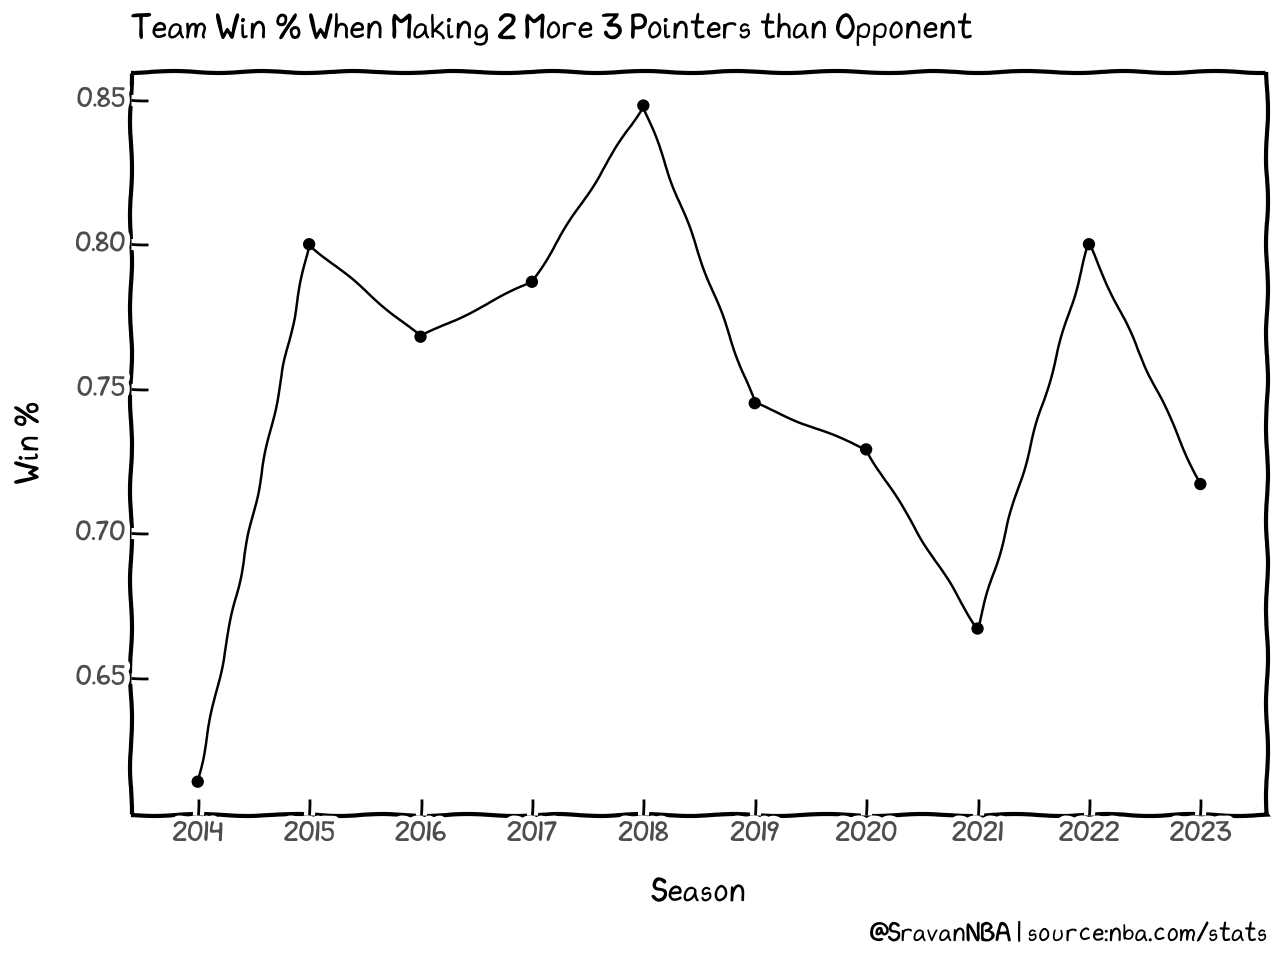

In [68]:
p = (
    ggplot(df_mw)
    + aes(x="Season", y= "Win_PCT")
    + geom_line(group=1)
    + geom_point()
    + theme_idv
    + labs(
            title= "Team Win % When Making 2 More 3 Pointers than Opponent",
            caption="@SravanNBA | source:nba.com/stats",
            y = "Win %",
        )
    + theme(plot_title=element_text(face="bold", size=11.5))
)
p.draw()

# 3FG% vs Wins Year to Year

### Team 3P% > Opponent 3P%

In [77]:
dfa = []
for season in range(2013,2023):
    df = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{season}_PS.parquet")
    df['Team_Split'] = df['MATCHUP'].str.replace("@","")
    df['Team_Split'] = df['Team_Split'].str.replace("vs.","")
    df[['Team1','Team2']] = df['Team_Split'].str.split("  ",expand=True)
    df[["FG3M","PLUS_MINUS","FG3_PCT"]] = df[["FG3M","PLUS_MINUS","FG3_PCT"]].astype(str)
    df1 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3_PCT","PLUS_MINUS"]].agg(",".join).reset_index()
    df1[["Team1", "Team2"]] = df1["TEAM_ABBREVIATION"].str.split(",", expand=True)
    df1[["FG3_PCT_For", "FG3_PCT_Against"]] = df1["FG3_PCT"].str.split(",", expand=True)
    df1[["PM1", "PM2"]] = df1["PLUS_MINUS"].str.split(",", expand=True)
    df2 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3_PCT","PLUS_MINUS"]].agg(",".join).reset_index()
    df2[["Team2", "Team1"]] = df2["TEAM_ABBREVIATION"].str.split(",", expand=True)
    df2[["FG3_PCT_Against","FG3_PCT_For"]] = df2["FG3_PCT"].str.split(",", expand=True)
    df2[["PM2", "PM1"]] = df2["PLUS_MINUS"].str.split(",", expand=True)
    df3 = pd.concat([df1,df2]).sort_values(by="GAME_ID").reset_index(drop=True)
    df3 = df3[["Team1","Team2","FG3_PCT_For", "FG3_PCT_Against","PM1","PM2"]]
    df3.iloc[:,2:] = df3.iloc[:,2:].astype(float)
    df3["More_3PT_PCT"] = df3["FG3_PCT_For"] > (df3["FG3_PCT_Against"] + 0.00) 
    df3["Win"] = df3["PM1"] > 0
    df3["Loss"] = df3["PM1"] < 0
    df3["Win_More_3PT_PCT"] = df3["More_3PT_PCT"] & df3["Win"]
    df3["Loss_More_3PT_PCT"] = df3["More_3PT_PCT"] & df3["Loss"]
    df4 = df3.groupby("Team1")[["Win_More_3PT_PCT","Loss_More_3PT_PCT"]]\
        .agg({"Win_More_3PT_PCT":["sum"],"Loss_More_3PT_PCT":["sum"]})
    df4.columns = ["Win_More_3PT_PCT","Loss_More_3PT_PCT"]
    df4 = df4.sort_values(by="Win_More_3PT_PCT",ascending=False).reset_index().rename(columns={"Team1":"Team"})
    df4.loc['Total']= df4.sum()
    df4.loc['Total','Team'] = "Total"
    df4.loc['Total','Team'] = season +1
    dft = df4.tail(1)
    dfa.append(dft)
df_pw = pd.concat(dfa).reset_index(drop=True)
df_pw = df_pw.rename(columns={"Team":"Season"})
df_pw["Win_PCT"] = (df_pw["Win_More_3PT_PCT"]/(df_pw["Win_More_3PT_PCT"]+df_pw["Loss_More_3PT_PCT"])).round(3)

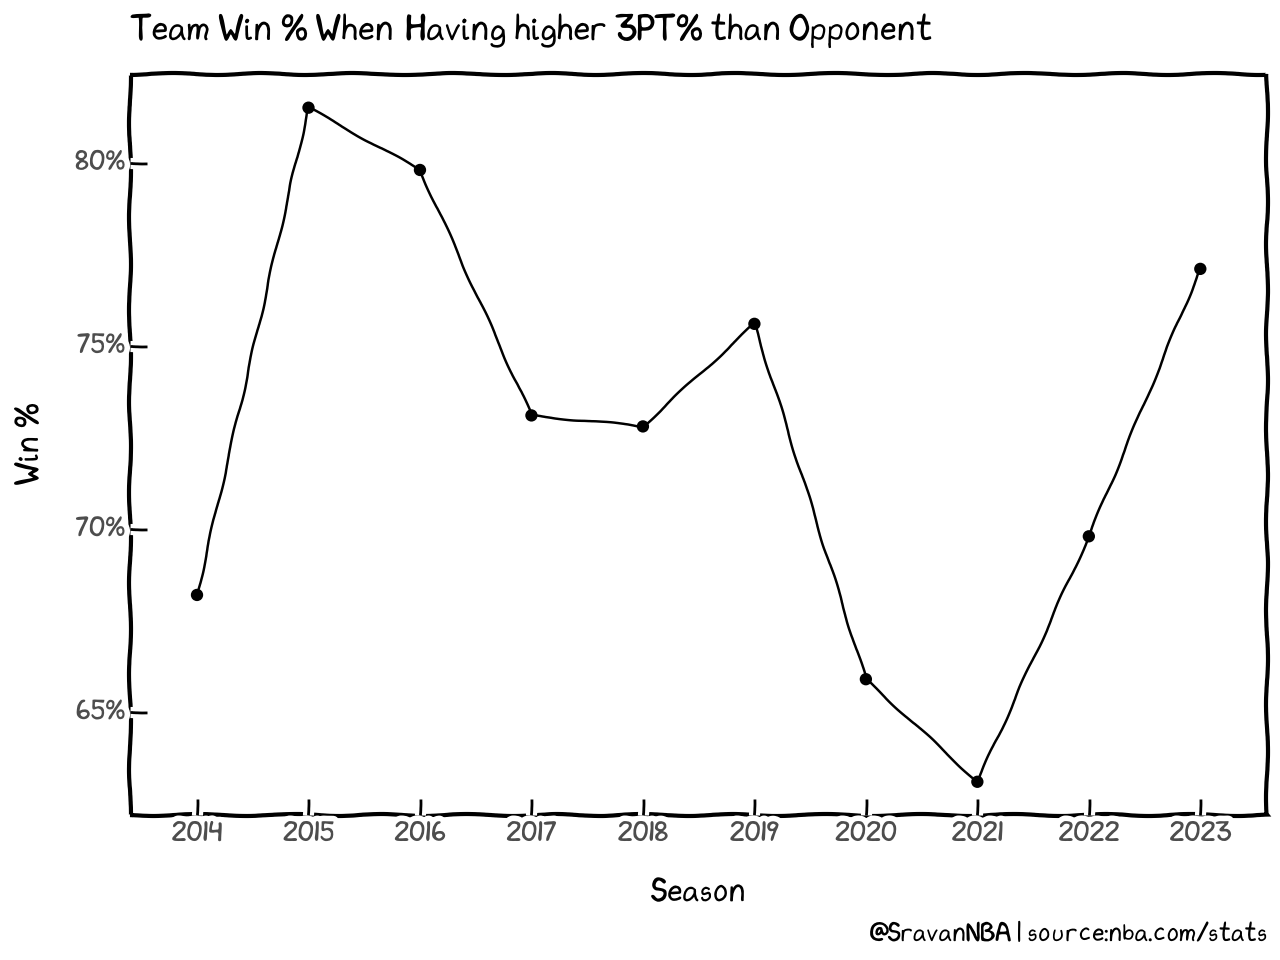

In [78]:
p = (
    ggplot(df_pw)
    + aes(x="Season", y= "Win_PCT")
    + geom_line(group=1)
    + geom_point()
    + scale_y_continuous(labels=percent_format())
    + theme_idv
    + labs(
            title= "Team Win % When Having higher 3PT% than Opponent",
            caption="@SravanNBA | source:nba.com/stats",
            y = "Win %",
        )
    + theme(plot_title=element_text(face="bold", size=12))
)
p.draw()

### Team 3P% > Opponent 3P% + 5%

In [81]:
dfa = []
for season in range(2013,2023):
    df = pd.read_parquet(box_DIR + f"NBA_Box_T_Base_{season}_PS.parquet")
    df['Team_Split'] = df['MATCHUP'].str.replace("@","")
    df['Team_Split'] = df['Team_Split'].str.replace("vs.","")
    df[['Team1','Team2']] = df['Team_Split'].str.split("  ",expand=True)
    df[["FG3M","PLUS_MINUS","FG3_PCT"]] = df[["FG3M","PLUS_MINUS","FG3_PCT"]].astype(str)
    df1 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3_PCT","PLUS_MINUS"]].agg(",".join).reset_index()
    df1[["Team1", "Team2"]] = df1["TEAM_ABBREVIATION"].str.split(",", expand=True)
    df1[["FG3_PCT_For", "FG3_PCT_Against"]] = df1["FG3_PCT"].str.split(",", expand=True)
    df1[["PM1", "PM2"]] = df1["PLUS_MINUS"].str.split(",", expand=True)
    df2 = df.groupby("GAME_ID")[["TEAM_ABBREVIATION","FG3_PCT","PLUS_MINUS"]].agg(",".join).reset_index()
    df2[["Team2", "Team1"]] = df2["TEAM_ABBREVIATION"].str.split(",", expand=True)
    df2[["FG3_PCT_Against","FG3_PCT_For"]] = df2["FG3_PCT"].str.split(",", expand=True)
    df2[["PM2", "PM1"]] = df2["PLUS_MINUS"].str.split(",", expand=True)
    df3 = pd.concat([df1,df2]).sort_values(by="GAME_ID").reset_index(drop=True)
    df3 = df3[["Team1","Team2","FG3_PCT_For", "FG3_PCT_Against","PM1","PM2"]]
    df3.iloc[:,2:] = df3.iloc[:,2:].astype(float)
    df3["More_3PT_PCT"] = df3["FG3_PCT_For"] > (df3["FG3_PCT_Against"] + 0.05) 
    df3["Win"] = df3["PM1"] > 0
    df3["Loss"] = df3["PM1"] < 0
    df3["Win_More_3PT_PCT"] = df3["More_3PT_PCT"] & df3["Win"]
    df3["Loss_More_3PT_PCT"] = df3["More_3PT_PCT"] & df3["Loss"]
    df4 = df3.groupby("Team1")[["Win_More_3PT_PCT","Loss_More_3PT_PCT"]]\
        .agg({"Win_More_3PT_PCT":["sum"],"Loss_More_3PT_PCT":["sum"]})
    df4.columns = ["Win_More_3PT_PCT","Loss_More_3PT_PCT"]
    df4 = df4.sort_values(by="Win_More_3PT_PCT",ascending=False).reset_index().rename(columns={"Team1":"Team"})
    df4.loc['Total']= df4.sum()
    df4.loc['Total','Team'] = "Total"
    df4.loc['Total','Team'] = season +1
    dft = df4.tail(1)
    dfa.append(dft)
df_pw = pd.concat(dfa).reset_index(drop=True)
df_pw = df_pw.rename(columns={"Team":"Season"})
df_pw["Win_PCT"] = (df_pw["Win_More_3PT_PCT"]/(df_pw["Win_More_3PT_PCT"]+df_pw["Loss_More_3PT_PCT"])).round(3)

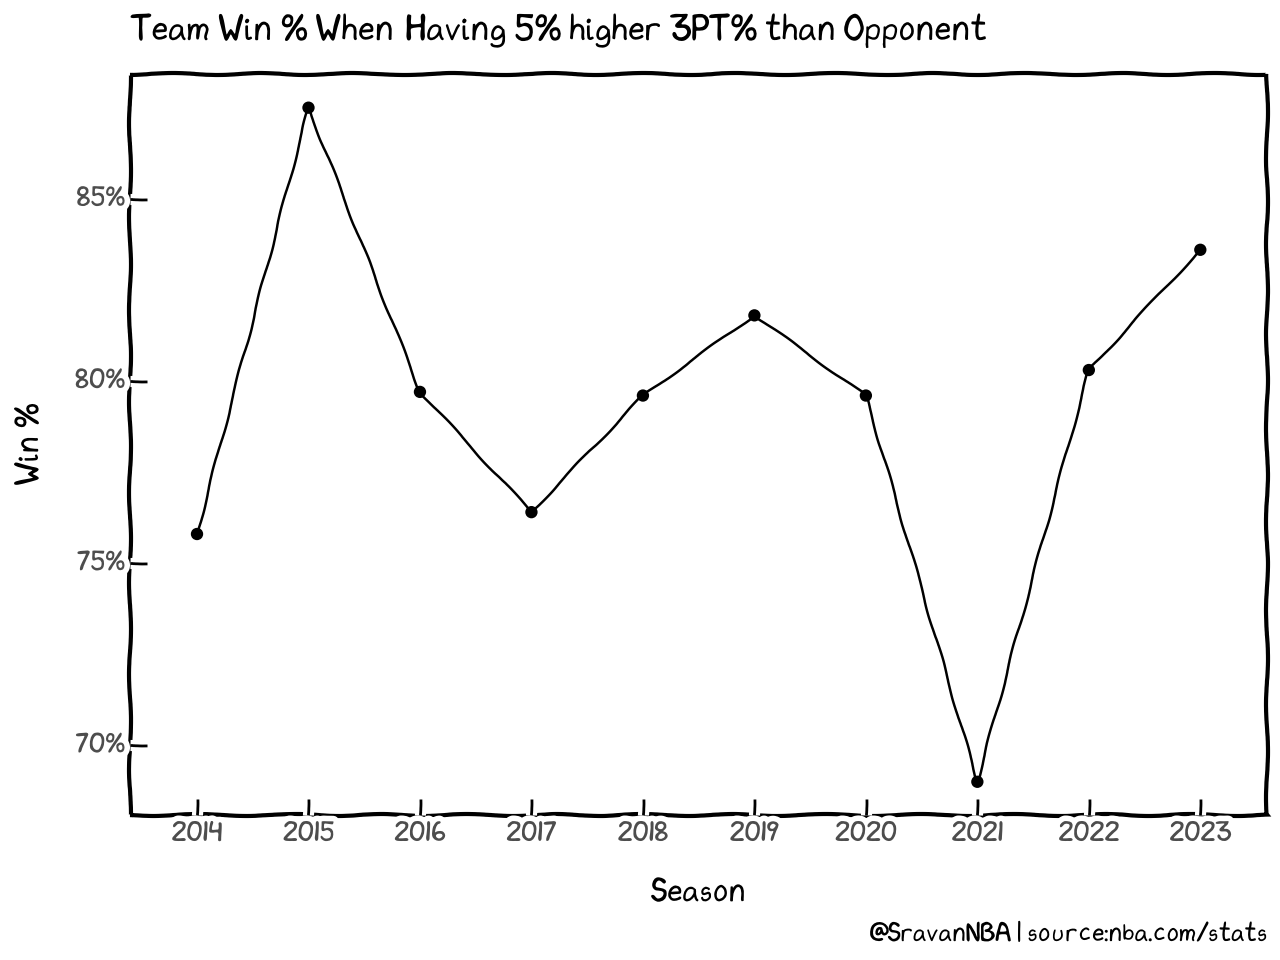

In [82]:
p = (
    ggplot(df_pw)
    + aes(x="Season", y= "Win_PCT")
    + geom_line(group=1)
    + geom_point()
    + scale_y_continuous(labels=percent_format())
    + theme_idv
    + labs(
            title= "Team Win % When Having 5% higher 3PT% than Opponent",
            caption="@SravanNBA | source:nba.com/stats",
            y = "Win %",
        )
    + theme(plot_title=element_text(face="bold", size=12))
)
p.draw()